In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.grid_search import GridSearchCV
from sklearn.feature_extraction.text import *
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import csv


Load merged data file with charging stations and ACS data aggregated by urban areas. Use raw count of stations as the labels (for now) and picked 11 attributes for modeling.

In [23]:
#import the merged charging station and ACS data
# to do: use imputer to handle missing vaules in scikit
# http://stackoverflow.com/questions/30317119/classifiers-in-scikit-learn-that-handle-nan-null?lq=1
#lines = open('data/missing_values_removed.csv').read().splitlines()
#Remove the first row, it's just the headings
# lines.pop(0)

#load urban area data
# input vectors for now, we use incentive, population, household, %owning houses, ...
X = np.loadtxt("data/parsed_urban_area_data.csv",delimiter = ',',usecols = (1,2,3,4,5,6,7,8,9,10)) 
# X = np.loadtxt("data/parsed_urban_area_data.csv",delimiter = ',',usecols = (1,3,4,5,6,7,8,9,10))
# labels for now, we use station count
Y = np.loadtxt("data/parsed_urban_area_data.csv",delimiter = ',',usecols = (0,),dtype=float)  
# feature names
feaname = ["Incentive","Population","Households","% Owning Homes",
          "Households $150-200K","Households >$200K", "Total College Grads",
          "Total Graduate Degree","% College Grads","Median Income"] # feature names of the attributes

print Y.shape, X.shape, len(X), X[4], Y[4]

# add shuffle code before splitting the data into train and dev sets
# easiest shuffle utility is sklearn shuffle function
from sklearn.utils import shuffle

# shuffle two arrays in unison
X, Y = shuffle(X, Y, random_state=0)
print Y.shape, X.shape, len(X), X[4], Y[4]
# determine the data type of the two arrays
print X.dtype, Y.dtype
# convert to strings
# must handle missing values first by making missing values zeros
X[X==''] = '0'
# now convert to float or leave them alone - converting now to make the code cleaner
X1=X.astype(np.float)
print X1.dtype

# Split the imported data into training 75% and development data 25%

split = 3*len(X)/4

print len(X), split

train_data, train_labels = X[:split], Y[:split]
dev_data, dev_labels = X[split:], Y[split:]

print train_data.shape, train_labels.shape
print dev_data.shape, dev_labels.shape
print train_data[1], train_labels[1]
print dev_data[0], dev_labels[0]
# dev_dat=np.array(dev_data)
# print dev_dat.sum()

(3584,) (3584, 10) 3584 [  0.00000000e+00   2.59770000e+04   1.12890000e+04   6.39206307e+01
   1.75000000e+02   2.37000000e+02   7.10000000e+00   7.10000000e+00
   2.67000000e+01   1.50000000e+01] 2.0
(3584,) (3584, 10) 3584 [  3.00000000e+00   5.62400000e+03   2.05800000e+03   6.68610301e+01
   3.20000000e+01   0.00000000e+00   9.40000000e+00   2.00000000e+00
   9.20000000e+00   7.00000000e+00] 0.0
float64 float64
float64
3584 2688
(2688, 10) (2688,)
(896, 10) (896,)
[  2.00000000e+00   7.67500000e+03   3.13200000e+03   5.62260536e+01
   3.60000000e+01   4.10000000e+01   8.80000000e+00   4.00000000e+00
   1.49000000e+01   1.35000000e+01] 2.0
[  2.00000000e+00   4.02800000e+03   1.47400000e+03   5.62415197e+01
   1.70000000e+01   0.00000000e+00   8.60000000e+00   5.40000000e+00
   1.22000000e+01   1.19000000e+01] 0.0


('Coefficients: \n', array([  2.20370811e-01,   1.68342950e-04,  -4.19549259e-04,
        -3.80050300e-02,   5.01445312e-03,  -3.54792452e-03,
         7.18462297e-02,   5.54344591e-02,   9.41617503e-02,
         4.55441486e-03]))
Variance score: 0.71
(896,) (896,)
0.0 361.0 -34.2299914706 388.469351755


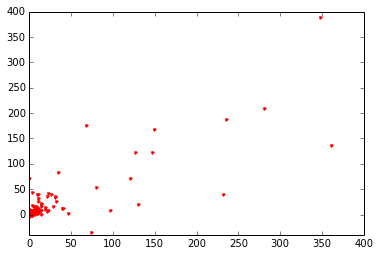

In [24]:
# try lineary regression mode
from sklearn import datasets, linear_model

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(train_data, train_labels)

# The coefficients
print('Coefficients: \n', regr.coef_)

# score
print('Variance score: %.2f' % regr.score(dev_data, dev_labels))

# predict the dev data set
dev_predictions=regr.predict(dev_data)
print dev_predictions.shape, dev_labels.shape
# print dev_predictions[0], dev_labels[0]
print np.amin(dev_labels), np.amax(dev_labels), np.amin(dev_predictions), np.amax(dev_predictions)

# visualize predicted vs actual labels
import matplotlib.pyplot as plt
plt.axis([0, 400, -40, 400])
plt.plot(dev_labels, dev_predictions, 'r.')
plt.show()

Interpretation of the Linear Regression model: Number of charging stations in each region is positively correlated to the population, percentage of male population, age, percentage of the population which is college educated, and income and negatively correlated to the percentage of home owners. The model predicts two charging stations for each 100,000 increase in population, ~0.08 charging stations for 10% increase in male percentage, ~0.07 charging stations for every 10 years increase in median age, ~0.1 charging station for every 10% increase in % of college educated, and ~0.14 charging stations for every $10,000 increase in median income; and -0.17 charging stations for every 10 percentage increase in home ownership.  As an example, the simple linear model predicts 1.5 charging stations for Coppell, Texas (vs. 3 actual charging stations). The underestimate is due to the combination of the high percentage of home owership (74 percent) and relatively small population (less than 40,000).

In [25]:
# fit the first model with logistic regression 
#
logreg = LogisticRegression(penalty='l1', C=1.0, tol=0.01) 
logreg.fit(train_data, train_labels)

# examine predict prob for test data
print logreg.predict_proba(dev_data).shape, dev_labels.shape

# coeff_ for predictor, e.g., 0th=incentive, 1st=pop, 2nd=household, 3rd=%owning home, etc
# vs labels - 0th =0 charging station, 1st =1 charging station etc....
print('Incentive Count vs Count of Charging Stations: \n', np.transpose(logreg.coef_)[0])

print('Home Ownership Percentage vs Count of Charging Stations: \n', np.transpose(logreg.coef_)[2])

# examine score for test data
print logreg.score(dev_data, dev_labels)

# predicting Coppell Texas with this LogReg model
# X_Coppell=np.array([39551,0.488938333,37.9,22.1,64572,0.721044394])

# print logreg.predict_proba(X_Coppell)

(896, 65) (896,)
('Incentive Count vs Count of Charging Stations: \n', array([ -1.96236976e-02,   6.09153345e-03,   1.74517199e-02,
         1.53753765e-02,   3.01188966e-02,   6.43449357e-02,
         4.29892600e-02,   3.51581750e-02,   9.74590547e-02,
         1.04217713e-01,  -5.66625879e-02,   1.37703548e-01,
         0.00000000e+00,  -3.11799174e-02,  -2.59368477e-01,
         1.89808285e-01,   0.00000000e+00,  -7.67257888e-02,
        -1.14782789e-01,   8.96394750e-02,   0.00000000e+00,
         4.94565099e-02,   7.11858093e-02,   5.43851402e-02,
        -6.37500335e-02,  -8.16179200e-02,   1.56491980e-01,
        -4.92756434e-02,   1.09137608e-01,  -2.80474849e-04,
         1.94269394e-01,  -7.03671704e-01,   1.08092126e-01,
         2.71359598e-02,  -2.22253433e-01,  -1.73853100e-01,
        -1.15314759e-01,   1.30383544e-01,  -4.69023062e-01,
        -1.18188292e+00,   1.23701049e-01,   0.00000000e+00,
         0.00000000e+00,  -2.62429550e-01,  -1.19300915e-01,
        -5.655

Logistic Regression showed similar results although the score is much higher for the test data set 86%. However, in reality, the predicting power of the model is limited. E.g., for Coppell, Texas, the model predicts 30.5% probability of 0, 32.0% of 1, 17.1% of 2 charging stations, etc.. The example is slightly unfair as Coppell is a small town of less than 40,000 residents, and with moderately high income (positive) and home owing percegtage (negative).

Improvements to the model. Play with the class weight parameter, perhaps to underweigh data points with 0 charging stations and overweigh these with higher counts of charging stations. 

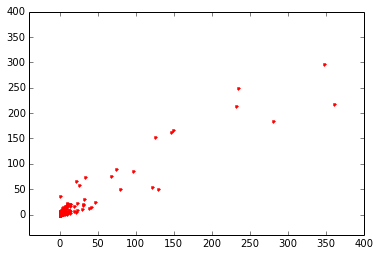

0.896446189113 1.85981696429 64.7620201964 0.896369264542
1. feature 4  Households $150-200K (0.341100)
2. feature 5  Households >$200K (0.338813)
3. feature 1  Population (0.115590)
4. feature 2  Households (0.070511)
5. feature 3  % Owning Homes (0.058649)
6. feature 7  Total Graduate Degree (0.019978)
7. feature 6  Total College Grads (0.016561)
8. feature 8  % College Grads (0.014341)
9. feature 9  Median Income (0.013805)
10. feature 0  Incentive (0.010653)


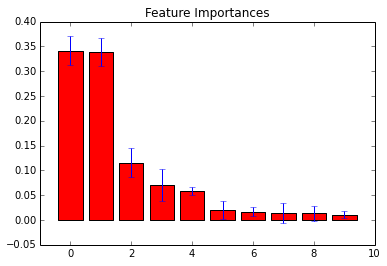

In [33]:
# random forest modeling

random = RandomForestRegressor(n_estimators=250)
random.fit(train_data, train_labels)

# Make predictions on dev data
dev_predictions = random.predict(dev_data)

plt.axis([-40, 400, -40, 400])
plt.plot(dev_labels, dev_predictions, 'r.')
plt.show()

_explained_variance_score = explained_variance_score(dev_labels, dev_predictions)
_mean_absolute_error = mean_absolute_error(dev_labels, dev_predictions)
_mean_squared_error = mean_squared_error(dev_labels, dev_predictions)
_r2_score = r2_score(dev_labels, dev_predictions)

print _explained_variance_score, _mean_absolute_error, _mean_squared_error, _r2_score

# predicting charging station count for Coppell Texas
#X_Coppell=np.array([39551,0.488938333,37.9,22.1,64572,0.721044394])
# print random.predict(X_Coppell)

# evaluate the importances of the features
importances = random.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
            axis=0)
indices = np.argsort(importances)[::-1]

for f in range(10):
    print("%d. feature %d  %s (%f)" % ( f + 1, indices[f], feaname[indices[f]], importances[indices[f]]))

# plot the feature importances
plt.figure()
plt.title("Feature Importances")
plt.bar(range(10), importances[indices], 
       color='r', yerr=std[indices], align="center")
plt.xlim([-1,10])
plt.show()

1. feature 2  Households (0.128531)
2. feature 1  Population (0.121140)
3. feature 5  Households >$200K (0.118313)
4. feature 4  Households $150-200K (0.116346)
5. feature 8  % College Grads (0.098222)
6. feature 9  Median Income (0.092710)
7. feature 7  Total Graduate Degree (0.091209)
8. feature 3  % Owning Homes (0.088153)
9. feature 6  Total College Grads (0.081428)
10. feature 0  Incentive (0.063949)


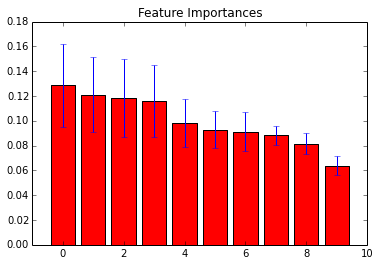

In [35]:
# try to rank importance of features from 250 Decision Trees 
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
# fit the whole data set and calcualte feature importances
forest.fit(X, Y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
            axis=0)
indices = np.argsort(importances)[::-1]

for f in range(10):
    print("%d. feature %d  %s (%f)" % ( f + 1, indices[f], feaname[indices[f]], importances[indices[f]]))

# plot the feature importances
plt.figure()
plt.title("Feature Importances")
plt.bar(range(10), importances[indices], 
       color='r', yerr=std[indices], align="center")
plt.xlim([-1,10])
plt.show()